## Imports
Nous utiliserons la bibliothèque de stopwords de nltk ainsi que l'outil spacy pour la lemmatization

In [1]:
# Run in python console
import nltk
nltk.download('stopwords')

# Run in terminal or command prompt
#python3 -m spacy download en

[nltk_data] Downloading package stopwords to /home/rym/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

Les principaux packages utilisés seront re, gensim, spacy et pyLDAvis

In [2]:
import re
import numpy as np
import pandas as pd
from pprint import pprint
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel


import spacy

import pyLDAvis
import pyLDAvis.gensim 
import matplotlib.pyplot as plt
%matplotlib inline

import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [3]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

## Import des données

Nous utiliserons le dataset "20-Newsgroups" contenant 11 000 posts de 20 thèmes différents.

In [4]:
# Import Dataset
df = pd.read_json('https://raw.githubusercontent.com/selva86/datasets/master/newsgroups.json')
print(df.target_names.unique())
df.head()

['rec.autos' 'comp.sys.mac.hardware' 'comp.graphics' 'sci.space'
 'talk.politics.guns' 'sci.med' 'comp.sys.ibm.pc.hardware'
 'comp.os.ms-windows.misc' 'rec.motorcycles' 'talk.religion.misc'
 'misc.forsale' 'alt.atheism' 'sci.electronics' 'comp.windows.x'
 'rec.sport.hockey' 'rec.sport.baseball' 'soc.religion.christian'
 'talk.politics.mideast' 'talk.politics.misc' 'sci.crypt']


,content,target,target_names
0,From: lerxst@wam.umd.edu (where's my thing)\nS...,7,rec.autos
1,From: guykuo@carson.u.washington.edu (Guy Kuo)...,4,comp.sys.mac.hardware
2,From: twillis@ec.ecn.purdue.edu (Thomas E Will...,4,comp.sys.mac.hardware
3,From: jgreen@amber (Joe Green)\nSubject: Re: W...,1,comp.graphics
4,From: jcm@head-cfa.harvard.edu (Jonathan McDow...,14,sci.space


On enlève les emails, les retours à la ligne et les espaces en trop avec des expressions régulières.

In [5]:
# Convert to list
data = df.content.values.tolist()

# Remove Emails
data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]

# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]

pprint(data[:1])

['From: (wheres my thing) Subject: WHAT car is this!? Nntp-Posting-Host: '
 'rac3.wam.umd.edu Organization: University of Maryland, College Park Lines: '
 '15 I was wondering if anyone out there could enlighten me on this car I saw '
 'the other day. It was a 2-door sports car, looked to be from the late 60s/ '
 'early 70s. It was called a Bricklin. The doors were really small. In '
 'addition, the front bumper was separate from the rest of the body. This is '
 'all I know. If anyone can tellme a model name, engine specs, years of '
 'production, where this car is made, history, or whatever info you have on '
 'this funky looking car, please e-mail. Thanks, - IL ---- brought to you by '
 'your neighborhood Lerxst ---- ']


## Tokenization et nettoyage du texte

On tokenise chaque phrase en enlevant la ponctuation et les caractères inutiles. Pour ce faire gensim propose la méthode simple_preprocess()

In [6]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:1])

[['from', 'wheres', 'my', 'thing', 'subject', 'what', 'car', 'is', 'this', 'nntp', 'posting', 'host', 'rac', 'wam', 'umd', 'edu', 'organization', 'university', 'of', 'maryland', 'college', 'park', 'lines', 'was', 'wondering', 'if', 'anyone', 'out', 'there', 'could', 'enlighten', 'me', 'on', 'this', 'car', 'saw', 'the', 'other', 'day', 'it', 'was', 'door', 'sports', 'car', 'looked', 'to', 'be', 'from', 'the', 'late', 'early', 'it', 'was', 'called', 'bricklin', 'the', 'doors', 'were', 'really', 'small', 'in', 'addition', 'the', 'front', 'bumper', 'was', 'separate', 'from', 'the', 'rest', 'of', 'the', 'body', 'this', 'is', 'all', 'know', 'if', 'anyone', 'can', 'tellme', 'model', 'name', 'engine', 'specs', 'years', 'of', 'production', 'where', 'this', 'car', 'is', 'made', 'history', 'or', 'whatever', 'info', 'you', 'have', 'on', 'this', 'funky', 'looking', 'car', 'please', 'mail', 'thanks', 'il', 'brought', 'to', 'you', 'by', 'your', 'neighborhood', 'lerxst']]


## Création de modèles de Bigrammes et de Trigrammes

On definit un modèle de sélection de bigrammes et un modèle de séléction de trigrammes. L'argument min_count determine le nombre minimum de fois qu'un bigrammes doit être observé dans le document pour être pris. L'argument threshold représente le score minimum de la phrase pour en séléctionner un bigramme (ou trigramme) celà dépend de la fonction de scoring considérée (importance de la phrase).

In [7]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['from', 'wheres', 'my', 'thing', 'subject', 'what', 'car', 'is', 'this', 'nntp_posting_host', 'rac_wam_umd_edu', 'organization', 'university', 'of', 'maryland_college_park', 'lines', 'was', 'wondering', 'if', 'anyone', 'out', 'there', 'could', 'enlighten', 'me', 'on', 'this', 'car', 'saw', 'the', 'other', 'day', 'it', 'was', 'door', 'sports', 'car', 'looked', 'to', 'be', 'from', 'the', 'late', 'early', 'it', 'was', 'called', 'bricklin', 'the', 'doors', 'were', 'really', 'small', 'in', 'addition', 'the', 'front_bumper', 'was', 'separate', 'from', 'the', 'rest', 'of', 'the', 'body', 'this', 'is', 'all', 'know', 'if', 'anyone', 'can', 'tellme', 'model', 'name', 'engine', 'specs', 'years', 'of', 'production', 'where', 'this', 'car', 'is', 'made', 'history', 'or', 'whatever', 'info', 'you', 'have', 'on', 'this', 'funky', 'looking', 'car', 'please', 'mail', 'thanks', 'il', 'brought', 'to', 'you', 'by', 'your', 'neighborhood', 'lerxst']


## Stopwords, bigrammes et lemmatisation

In [8]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [9]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['where', 'thing', 'car', 'nntp_poste', 'host', 'park', 'line', 'wonder', 'could', 'enlighten', 'car', 'see', 'day', 'door', 'sport', 'car', 'look', 'late', 'early', 'call', 'bricklin', 'door', 'really', 'small', 'addition', 'separate', 'rest', 'body', 'know', 'tellme', 'model', 'name', 'engine', 'year', 'production', 'car', 'make', 'history', 'info', 'funky', 'look', 'car', 'mail', 'thank', 'bring', 'neighborhood', 'lerxst']]


## Création du dictionnaire et du corpus pour le Topic Modeling

In [12]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1]) #(word_id,word_frequency)

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 5), (6, 1), (7, 1), (8, 2), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 2), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1), (34, 1), (35, 1), (36, 1), (37, 1), (38, 1), (39, 1), (40, 1)]]


In [13]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('addition', 1),
  ('body', 1),
  ('bricklin', 1),
  ('bring', 1),
  ('call', 1),
  ('car', 5),
  ('could', 1),
  ('day', 1),
  ('door', 2),
  ('early', 1),
  ('engine', 1),
  ('enlighten', 1),
  ('funky', 1),
  ('history', 1),
  ('host', 1),
  ('info', 1),
  ('know', 1),
  ('late', 1),
  ('lerxst', 1),
  ('line', 1),
  ('look', 2),
  ('mail', 1),
  ('make', 1),
  ('model', 1),
  ('name', 1),
  ('neighborhood', 1),
  ('nntp_poste', 1),
  ('park', 1),
  ('production', 1),
  ('really', 1),
  ('rest', 1),
  ('see', 1),
  ('separate', 1),
  ('small', 1),
  ('sport', 1),
  ('tellme', 1),
  ('thank', 1),
  ('thing', 1),
  ('where', 1),
  ('wonder', 1),
  ('year', 1)]]

## Construction du modèle de mots

In [15]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

On peut ici voir les mots-clés par ordre d'importance pour chaque thème 

In [16]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.097*"black" + 0.073*"wing" + 0.072*"white" + 0.048*"vote" + '
  '0.041*"flight" + 0.028*"devil" + 0.027*"capacity" + 0.024*"trace" + '
  '0.023*"assist" + 0.022*"penalty"'),
 (1,
  '0.064*"man" + 0.040*"god" + 0.039*"accept" + 0.034*"explain" + '
  '0.030*"member" + 0.029*"age" + 0.027*"israeli" + 0.027*"season" + '
  '0.024*"publish" + 0.021*"serious"'),
 (2,
  '0.130*"board" + 0.054*"expansion" + 0.032*"looking" + 0.016*"stuff_delete" '
  '+ 0.011*"rod" + 0.000*"reluctant" + 0.000*"wire" + 0.000*"connect" + '
  '0.000*"worked" + 0.000*"blanking"'),
 (3,
  '0.060*"reality" + 0.053*"picture" + 0.050*"object" + 0.042*"greek" + '
  '0.038*"contain" + 0.036*"generate" + 0.034*"interface" + 0.030*"font" + '
  '0.029*"concept" + 0.026*"workstation"'),
 (4,
  '0.215*"ax" + 0.182*"max" + 0.040*"orbit" + 0.035*"satellite" + '
  '0.034*"mission" + 0.026*"launch" + 0.022*"moon" + 0.020*"shuttle" + '
  '0.018*"spacecraft" + 0.017*"lunar"'),
 (5,
  '0.032*"kill" + 0.024*"child" + 0.023*"

## Evaluation d'un model avec Model Perplexity et Coherence score

In [17]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -12.920926063032306

Coherence Score:  0.4349993277965744


## Visualisation

In [18]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
19     0.358059 -0.053214       1        1  35.991370
17     0.309799  0.081330       2        1  20.078813
7      0.334988 -0.174002       3        1  15.996379
6      0.136896  0.319769       4        1   4.392652
5      0.145864 -0.201428       5        1   4.198498
9      0.077084  0.205795       6        1   3.528201
18     0.052111  0.004568       7        1   2.235064
1     -0.024043  0.018688       8        1   2.171833
16     0.014541 -0.107597       9        1   2.114533
8     -0.083174 -0.019960      10        1   1.322645
11    -0.059052  0.110549      11        1   1.243625
13    -0.093469  0.013586      12        1   1.197015
4     -0.140577 -0.023638      13        1   1.120968
12    -0.111026 -0.009143      14        1   1.108071
3     -0.137836 -0.027450      15        1   0.775677
14    -0.128115 -0.030053      16        1   0.732276
15    -0.143519 -0.025522      17        1   0.684310
10    -0.149003 -0.022666      18        1   0.604033
0     -0.162946 -0.027580      19        1   0.413320
2     -0.196582 -0.032031      20        1   0.090717, topic_info=        Term          Freq         Total Category  logprob  loglift
174    would  16156.000000  16156.000000  Default  30.0000  30.0000
19      line  15862.000000  15862.000000  Default  29.0000  29.0000
197    write  13427.000000  13427.000000  Default  28.0000  28.0000
3685      ax   2717.000000   2717.000000  Default  27.0000  27.0000
40      year   4625.000000   4625.000000  Default  26.0000  26.0000
...      ...           ...           ...      ...      ...      ...
3949    item      0.019669      1.238911  Topic20 -10.8605   2.8622
6920   frame      0.019669      1.238865  Topic20 -10.8605   2.8622
5769  hockey      0.019669      1.238940  Topic20 -10.8605   2.8622
3141  dollar      0.019669      1.238869  Topic20 -10.8605   2.8622
3382     pin      0.019669      1.238986  Topic20 -10.8605   2.8622

[836 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
472      10  0.989007   absolute
2857     19  0.946952   abstract
1211      8  0.999228     accept
853      11  0.995114   accident
1014     17  0.986950   accuracy
...     ...       ...        ...
40        2  0.250546       year
40        5  0.075445       year
40        7  0.302644       year
720       7  0.992505  yesterday
570       3  0.997661      young

[1001 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[20, 18, 8, 7, 6, 10, 19, 2, 17, 9, 12, 14, 5, 13, 4, 15, 16, 11, 1, 3])

## Construction d'un modèle LDA Mallet Model

In [20]:
# Download File: http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
mallet_path = 'mallet-2.0.8/bin/mallet' # update this path
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=20, id2word=id2word)



In [21]:
# Show Topics
pprint(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(10,
  [('good', 0.05334525406049769),
   ('thing', 0.04189284117759755),
   ('make', 0.03918939055282372),
   ('time', 0.024501351725312388),
   ('bad', 0.021499882921429635),
   ('give', 0.019137024501351727),
   ('read', 0.018988015411797263),
   ('problem', 0.01796623879770952),
   ('point', 0.016859314132447793),
   ('find', 0.016646444004512848)]),
 (15,
  [('people', 0.02114244798918016),
   ('happen', 0.015732527149051274),
   ('time', 0.015573411830223954),
   ('day', 0.013683917419149528),
   ('start', 0.012729225506185608),
   ('leave', 0.012550220772504873),
   ('back', 0.010839731095111181),
   ('live', 0.010302716894068977),
   ('hear', 0.009109352002864076),
   ('child', 0.00885078960976968)]),
 (17,
  [('key', 0.04004978441569987),
   ('system', 0.017624572165177578),
   ('encryption', 0.01480197359647953),
   ('bit', 0.012690580966351069),
   ('chip', 0.012246077254745077),
   ('phone', 0.011823798728719385),
   ('government', 0.011379295017113393),
   ('technology', 

## Comment détérminer le nombre optimal de thèmes pour LDA

In [22]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [23]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=40, step=6)



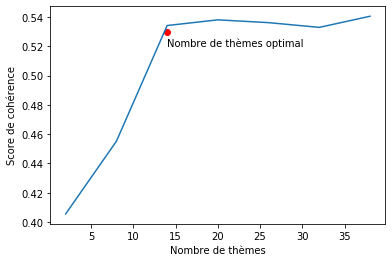

In [24]:
# Show graph
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.scatter(14,0.5297, c='r', marker='o')
plt.text(14,0.52,'Nombre de thèmes optimal',horizontalalignment='left')
plt.xlabel("Nombre de thèmes")
plt.ylabel("Score de cohérence")
#plt.legend(("coherence_values"), loc='best')
plt.show()

In [25]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.4056
Num Topics = 8  has Coherence Value of 0.4552
Num Topics = 14  has Coherence Value of 0.5342
Num Topics = 20  has Coherence Value of 0.5381
Num Topics = 26  has Coherence Value of 0.5362
Num Topics = 32  has Coherence Value of 0.533
Num Topics = 38  has Coherence Value of 0.5406


In [26]:
# Select the model and print the topics
optimal_model = model_list[3]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.012*"problem" + 0.012*"drug" + 0.011*"study" + 0.009*"food" + '
  '0.009*"effect" + 0.008*"case" + 0.008*"doctor" + 0.007*"find" + '
  '0.007*"patient" + 0.007*"eat"'),
 (1,
  '0.049*"file" + 0.029*"window" + 0.021*"program" + 0.018*"set" + '
  '0.013*"server" + 0.013*"line" + 0.012*"application" + 0.010*"change" + '
  '0.009*"run" + 0.009*"entry"'),
 (2,
  '0.020*"question" + 0.017*"exist" + 0.014*"claim" + 0.014*"argument" + '
  '0.014*"reason" + 0.013*"true" + 0.013*"evidence" + 0.009*"science" + '
  '0.009*"point" + 0.009*"answer"'),
 (3,
  '0.021*"make" + 0.018*"work" + 0.016*"money" + 0.014*"people" + 0.014*"pay" '
  '+ 0.013*"year" + 0.012*"job" + 0.009*"government" + 0.008*"support" + '
  '0.008*"time"'),
 (4,
  '0.186*"ax" + 0.166*"line" + 0.150*"max" + 0.101*"host" + 0.043*"nntp_poste" '
  '+ 0.031*"organization" + 0.017*"ca" + 0.012*"reply" + '
  '0.012*"distribution_usa" + 0.010*"university"'),
 (5,
  '0.018*"book" + 0.016*"word" + 0.011*"church" + 0.010*"day" + 0

## Trouver le thème dominant dans une phrase

In [27]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,13.0,0.1769,"car, buy, price, sell, bike, sale, ride, engin...",From: (wheres my thing) Subject: WHAT car is t...
1,1,17.0,0.1469,"drive, problem, card, system, driver, work, ru...",From: (Guy Kuo) Subject: SI Clock Poll - Final...
2,2,10.0,0.1400,"good, make, thing, write, bad, time, lot, line...",From: (Thomas E Willis) Subject: PB questions....
3,3,10.0,0.1246,"good, make, thing, write, bad, time, lot, line...",From: (Joe Green) Subject: Re: Weitek P9000 ? ...
4,4,1.0,0.1519,"file, window, program, set, server, line, appl...",From: (Jonathan McDowell) Subject: Re: Shuttle...
5,5,11.0,0.2937,"gun, law, state, people, case, crime, weapon, ...",From: (Foxvog Douglas) Subject: Re: Rewording ...
6,6,7.0,0.1103,"post, mail, send, information, list, group, ad...",From: (brian manning delaney) Subject: Brain T...
7,7,17.0,0.4861,"drive, problem, card, system, driver, work, ru...",From: (GRUBB) Subject: Re: IDE vs SCSI Organiz...
8,8,1.0,0.1367,"file, window, program, set, server, line, appl...",From: Subject: WIn 3.0 ICON HELP PLEASE! Organ...
9,9,17.0,0.2394,"drive, problem, card, system, driver, work, ru...",From: (Stan Kerr) Subject: Re: Sigma Designs D...


In [28]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_mallet.head()


,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.6739,"problem, drug, study, food, effect, case, doct...",From: Subject: How To Prevent Kidney Stone For...
1,1.0,0.9222,"file, window, program, set, server, line, appl...",From: (Landon C. Noll) Subject: 10th Internati...
2,2.0,0.6556,"question, exist, claim, argument, reason, true...",From: (Petri Pihko) Subject: Re: Atheists view...
3,3.0,0.7686,"make, work, money, people, pay, year, job, gov...",From: (Clinton/Gore 92) Subject: CLINTON: Back...
4,4.0,0.9713,"ax, line, max, host, nntp_poste, organization,...",Subject: roman.bmp 12/14 From: (Cliff) Reply-T...


In [29]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics

,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0.0,13.0,"car, buy, price, sell, bike, sale, ride, engin...",504.0,0.0445
1.0,17.0,"drive, problem, card, system, driver, work, ru...",681.0,0.0602
2.0,10.0,"good, make, thing, write, bad, time, lot, line...",413.0,0.0365
3.0,10.0,"good, make, thing, write, bad, time, lot, line...",314.0,0.0278
4.0,1.0,"file, window, program, set, server, line, appl...",359.0,0.0317
...,...,...,...,...
11309.0,0.0,"problem, drug, study, food, effect, case, doct...",NaN,NaN
11310.0,8.0,"line, power, work, current, ground, point, wir...",NaN,NaN
11311.0,17.0,"drive, problem, card, system, driver, work, ru...",NaN,NaN
11312.0,8.0,"line, power, work, current, ground, point, wir...",NaN,NaN
